In [102]:
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
from numpy import *
import numpy as np

def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=700)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')

### Linear model
The linear model generates sampels as

$$
y = \langle x,\beta \rangle + z,
$$

where $x \in \mathbb R^d$ is zero-mean Gaussian with diagonal co-variance matrix with diagonal $[\sigma_1^2,\ldots,\sigma_n^2]$, and $z$ is zero-mean Gaussian with variance $\sigma^2$.

In [2]:
class linear_model():
    def __init__(self,d,sigma_noise=0,beta=None,sigmas=None,normalized=True):
        self.d = d
        if beta is None:
            self.beta = np.random.randn(self.d)
            #self.beta = np.ones(self.d)
        else:
            self.beta = beta
        
        self.sigma_noise = sigma_noise
        
        if sigmas is None:
            if normalized:
                self.sigmas = np.ones(d) / np.sqrt(self.d)
            else:
                self.sigmas = np.ones(d)
        else:
            self.sigmas = sigmas
            
    def estimate_risk(self,estimator,avover=500):
        # estimator is an instance of a class with a predict function mapping x to a predicted y
        # function estimates the risk by averaging
        risk = 0
        for i in range(avover):
            x = np.random.randn(self.d) * self.sigmas 
            y = x @ self.beta + self.sigma_noise*np.random.randn(1)[0]
            risk += (y - estimator.predict(x))**2
        return risk/avover
    
    def compute_risk(self,hatbeta):
        # compute risk of a linear estimator based on formula
        return np.linalg.norm( self.beta - hatbeta )**2 + self.sigma_noise**2
    
    def sample(self,n):
        Xs = []
        ys = []
        for i in range(n):
            x = np.random.randn(self.d) * self.sigmas
            y = x @ self.beta + self.sigma_noise*np.random.randn(1)[0]
            Xs += [x]
            ys += [y]
        return np.array(Xs),np.array(ys)

# Two layer neural network model

We consider a two-layer neural network with ReLU non-linearities. The model is
$$
f(W,\theta) = \mathrm{relu}(W x) \theta \in \mathbb R,
$$
where $W \in \mathbb R^{m \times d}$ are the weights of the first layer, and $\theta \in \mathbb R^m$ are the weights in the second layer.

We consider the loss
$$
\sum_{i=1}^n  \frac{1}{2} ( f(W,\theta) - y_i )^2,
$$
which we optimize with respect to the weights $W$ and $\theta$ using gradient descent.

Note that 
$$
\frac{\partial L_i}{\partial w_j} 
=
( f(W,\theta) - y_i ) x_i a_j 1\{ w_j^T x_i >0 \}
$$
and
$$
\nabla_\theta L_i
=
\mathrm{relu}(W x) ( f(W,\theta) - y_i )
$$



In [3]:
class nn():
    def __init__(self,m,d,scale=1.0):
        self.m = m
        self.d = d
        ## initialization of model
        #self.theta = np.ones(m)/np.sqrt(m)
        #self.theta = np.random.choice(m, 2)
        # half 1s, half -1s
        
        self.theta = scale * np.array( [1]*int(m/2) + [-1]*(m-int(m/2)) ) / np.sqrt(m)
        self.W = (1/scale) * np.random.randn(m,d)
    
    def predict(self,x):
        sign = 1.0*( self.W @ x > 0 )
        prediction = np.dot(np.dot( (self.theta*sign).T  ,self.W),x)
        return prediction
    
    def compute_gradient(self,D):
        self.dW = np.zeros((self.m,self.d))
        self.dtheta = np.zeros(self.m)
        for (x,y) in D:
            yhat = self.predict(x)
            # W weights
            w = 2*(yhat - y)*x
            sign = 1.0*( self.W @ x > 0 )
            self.dW += np.outer(sign*self.theta,w)
            # theta weights
            reluWx = np.dot(self.W,x) * (np.dot(self.W,x)>0)
            self.dtheta += (yhat - y) * reluWx
                
    def compute_loss(self,D):
        loss = 0
        for (x,y) in D:
            loss += (1/np.sqrt(len(D)))*(y - self.predict(x) )**2
        return loss
 
    def update_model(self,D,stepsize=0.001):
        self.compute_gradient(D)
        self.W     = self.W     - stepsize*self.dW
        self.theta = self.theta - stepsize*self.theta
    
    def fit(self,D,t=100,stepsize=0.001):       
        losses = []
        for i in range(t):
            self.update_model(D,stepsize=stepsize)
            loss = self.compute_loss(D)
            losses += [loss]
        return losses

# Test neural network

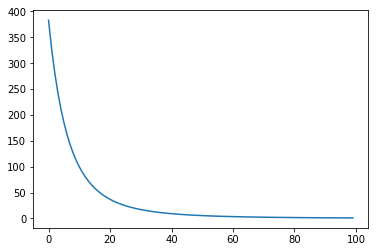

In [47]:
d = 50
n = 100
model = linear_model(d,sigma_noise=0.0,normalized=False)
Xs,ys = model.sample(n)
D = [(x,y) for x,y in zip(Xs,ys)]

m = 200
estimator = nn(m,d)

losses = estimator.fit(D,stepsize=0.001)

plt.plot(losses)
plt.show()

# Early stopping

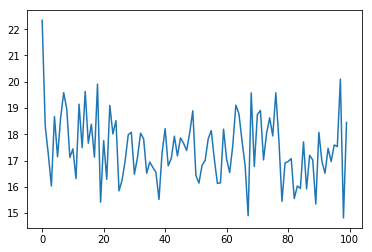

W change:  0.442421217444657
theta change:  0.04877176457496058


In [59]:
d = 50
n = 100
model = linear_model(d,sigma_noise=0.0,normalized=False)
Xs,ys = model.sample(n)
D = [(x,y) for x,y in zip(Xs,ys)]

m = 200
estimator = nn(m,d,scale=20.0)

theta0 = estimator.theta 
W0 = estimator.W

tmax = 100
risks = np.zeros(tmax)
for epoch in range(100):
    for t in range(10):
        estimator.update_model(D,stepsize=0.00005)
        risks[epoch] = model.estimate_risk(estimator)

plt.plot(risks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

In [ ]:
print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

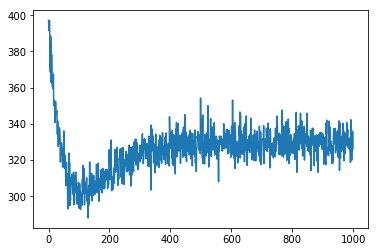

W change:  0.08480110242338544
theta change:  0.999954826654023


In [15]:
d = 25
n = 50
model = linear_model(d,sigma_noise=0.0,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=0.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

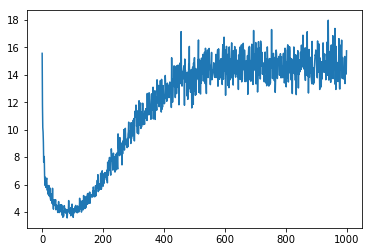

W change:  0.909350730107485
theta change:  0.9999548266540229


In [16]:
d = 25
n = 50
model = linear_model(d,sigma_noise=0.0,normalized=False)


numit = 1
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=1.0)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

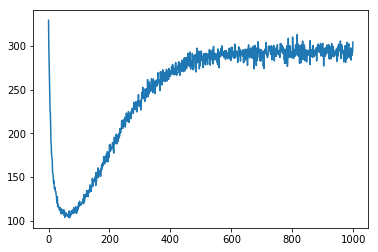

W change:  0.7334769647430968
theta change:  0.9999548266540229


In [17]:
d = 25
n = 50
model = linear_model(d,sigma_noise=0.0,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=0.5)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

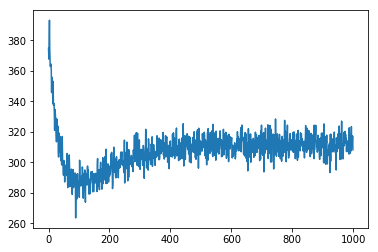

W change:  0.06412105773690886
theta change:  0.999954826654023


In [21]:
d = 25
n = 50
model = linear_model(d,sigma_noise=0.0,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=0.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

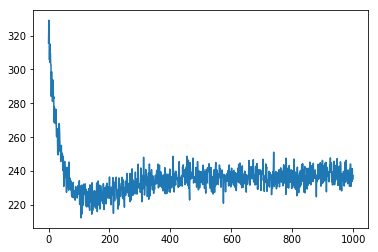

W change:  0.05873415301734244
theta change:  0.999954826654023


In [22]:
d = 25
n = 50
model = linear_model(d,sigma_noise=1.0,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=0.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

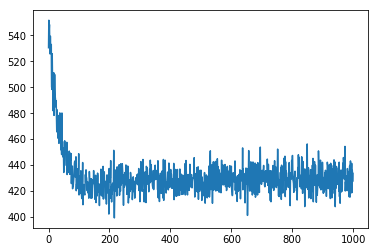

W change:  0.09221495939497383
theta change:  0.999954826654023


In [24]:
d = 25
n = 50
model = linear_model(d,sigma_noise=5.0,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=0.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

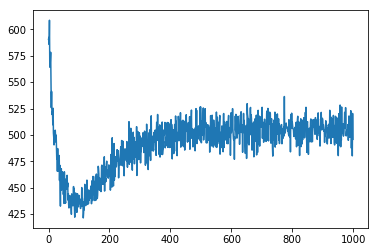

W change:  0.3394776455307563
theta change:  0.999954826654023


In [25]:
d = 25
n = 50
model = linear_model(d,sigma_noise=5.0,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=0.2)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

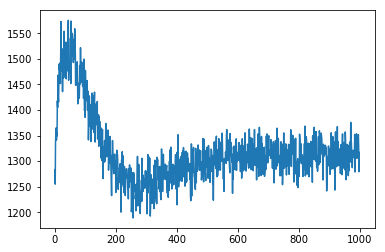

W change:  3.2266793763634563
theta change:  0.999954826654023


In [43]:
d = 20
n = 60
model = linear_model(d,sigma_noise=10.5,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=1.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

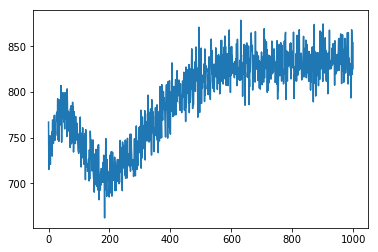

W change:  3.0929068333484953
theta change:  0.999954826654023


In [44]:
d = 20
n = 60
model = linear_model(d,sigma_noise=7.5,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=1.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

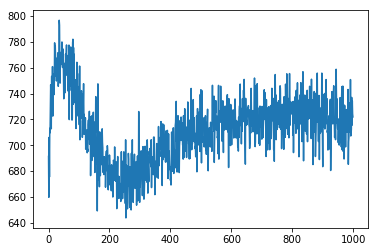

W change:  0.8604949573062471
theta change:  0.9999548266540218


In [56]:
d = 20
n = 60
model = linear_model(d,sigma_noise=7.5,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 1000
    estimator = nn(m,d,scale=1.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

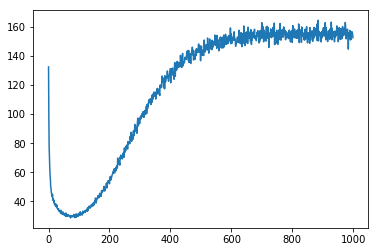

W change:  1.188677746508202
theta change:  0.999954826654023


In [46]:
d = 20
n = 60
model = linear_model(d,sigma_noise=0.5,normalized=False)


numit = 10
tmax = 1000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=1.1)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

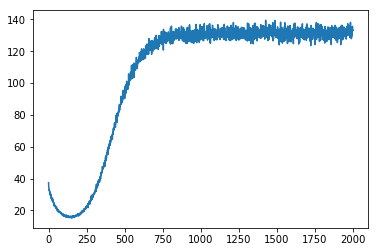

W change:  5.634891784637149
theta change:  0.9999999979593689


In [ ]:
d = 20
n = 60
model = linear_model(d,sigma_noise=0.5,normalized=False)


numit = 10
tmax = 2000
allrisks = np.zeros(tmax)
for it in range(numit):
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    m = 100
    estimator = nn(m,d,scale=5.0)

    theta0 = estimator.theta 
    W0 = estimator.W

    risks = np.zeros(tmax)
    for epoch in range(tmax):
        for t in range(10):
            estimator.update_model(D,stepsize=0.001)
        risks[epoch] = model.estimate_risk(estimator)
    allrisks += risks
        
plt.plot(allrisks)
plt.show()

print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

In [58]:
def simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100,scale=1.1):
    allrisks = np.zeros(tmax)
    for it in range(numit):
        Xs,ys = model.sample(n)
        D = [(x,y) for x,y in zip(Xs,ys)]
        estimator = nn(m,d,scale=scale)

        theta0 = estimator.theta 
        W0 = estimator.W

        risks = np.zeros(tmax)
        for epoch in range(tmax):
            for t in range(10):
                estimator.update_model(D,stepsize=stepsize)
                risks[epoch] = model.estimate_risk(estimator)
        allrisks += risks
        
    plt.plot(allrisks)
    plt.show()

    print("W change: ", np.linalg.norm(W0 - estimator.W) / np.linalg.norm(W0) )
    print("theta change: ", np.linalg.norm(theta0 - estimator.theta) / np.linalg.norm(theta0) )

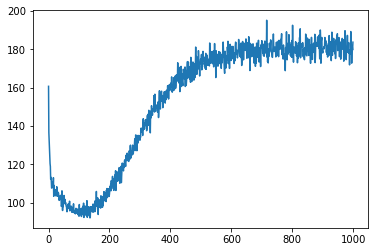

W change:  1.3550108144223416
theta change:  0.999954826654023


In [55]:
d = 20
n = 60
model = linear_model(d,sigma_noise=2.5,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100)  

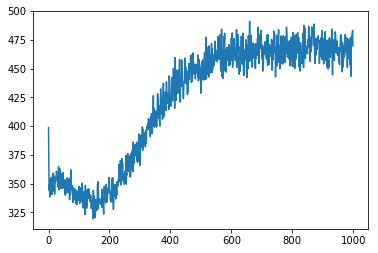

W change:  2.2972733915111925
theta change:  0.999954826654023


In [57]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100)  

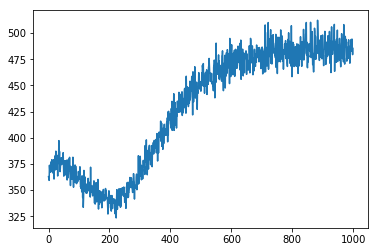

W change:  3.693470196250265
theta change:  0.9999548266540229


In [59]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100,scale=2.0)  

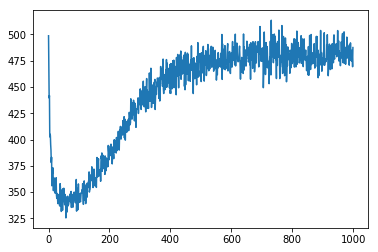

W change:  0.9046487246532553
theta change:  0.9999548266540229


In [60]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100,scale=0.5)  

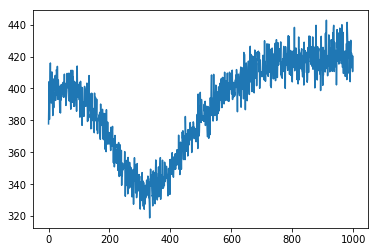

W change:  8.350997886887495
theta change:  0.9999548266540229


In [ ]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100,scale=5.0)  

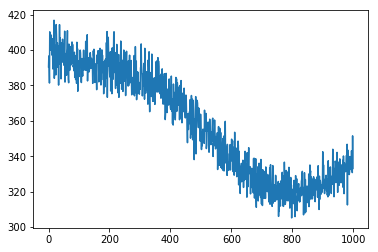

W change:  13.571876845383182
theta change:  0.9932704729778572


In [ ]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.0005,m = 100,scale=8.0)  

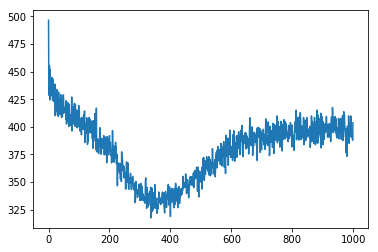

W change:  11.344472340072388
theta change:  0.9999548266540229


In [66]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.001,m = 100,scale=6.0)  

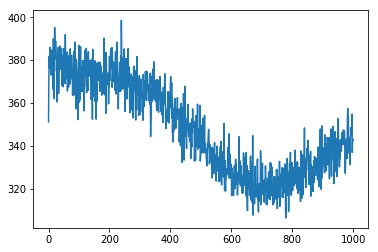

W change:  6.035081746953697
theta change:  0.993270472977858


In [68]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.0005,m = 300,scale=6.0)  

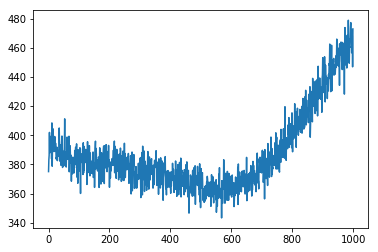

W change:  4.533964677631001
theta change:  0.9932704729778564


In [69]:
d = 20
n = 60
model = linear_model(d,sigma_noise=5.0,normalized=False)
simulate_model(model,n,numit = 10,tmax = 1000,stepsize=0.0005,m = 600,scale=6.0)  

In [85]:
a1 = np.random.randn(6)
a2 = np.random.randn(6)
a3 = np.random.randn(6)
a4 = np.random.randn(6)
A = np.array([a1,a2]).T
B = np.array([a3,a4]).T

In [86]:
A @ B.T - np.outer( a1 , a3.T) - np.outer( a2 , a4.T)

array([[ 0.00000000e+00,  1.83636743e-17, -5.55111512e-17,
         5.55111512e-17, -2.77555756e-17,  0.00000000e+00],
       [ 0.00000000e+00, -1.97866896e-17,  0.00000000e+00,
         5.55111512e-17,  0.00000000e+00, -4.44089210e-16],
       [ 5.55111512e-17,  7.26415456e-18, -1.11022302e-16,
        -2.77555756e-17,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.87313576e-18,  0.00000000e+00,
         2.77555756e-17,  0.00000000e+00, -1.11022302e-16],
       [-1.38777878e-17, -1.65069781e-17,  0.00000000e+00,
        -2.77555756e-17,  0.00000000e+00,  0.00000000e+00],
       [ 1.38777878e-17, -1.45689667e-18,  0.00000000e+00,
         6.93889390e-18,  1.38777878e-17,  0.00000000e+00]])

In [82]:
np.outer( a1 , a1.T)

array([[ 4.31989921, -3.43983392, -1.1822059 ,  1.17801827,  2.07292541,
        -1.60824649],
       [-3.43983392,  2.73905867,  0.94136269, -0.93802818, -1.65062164,
         1.28060878],
       [-1.1822059 ,  0.94136269,  0.32352856, -0.32238255, -0.56728746,
         0.44012103],
       [ 1.17801827, -0.93802818, -0.32238255,  0.3212406 ,  0.565278  ,
        -0.43856202],
       [ 2.07292541, -1.65062164, -0.56728746,  0.565278  ,  0.9947037 ,
        -0.77172518],
       [-1.60824649,  1.28060878,  0.44012103, -0.43856202, -0.77172518,
         0.59873082]])

# NTK for relu

In [4]:
n = 2
d = 2
k = 100000

X = np.random.randn(n,d)
#X = X / np.outer( np.linalg.norm(X,axis=1) , np.ones(d) )

E = np.zeros((n,n))
for i in range(k):
    relu = X @ np.random.randn(d)
    relu = relu * (relu > 0)
    E += np.outer( relu , relu.T) / k

def dual_kernel_relu(rho):
    print("rho:\n", rho)
    #return 1/(2*pi)*np.sqrt(1 - rho**2)*rho + 1/2 * (1 - np.arccos( rho )/pi) * rho
    return 1/(2*pi) * ( np.sqrt(1-rho**2) + (pi - np.arccos(rho))*rho )

# normalize rows
XN = X / np.outer( np.linalg.norm(X,axis=1) , np.ones(d) )
rho = XN @ XN.T

EX = dual_kernel_relu(rho) * np.outer( np.linalg.norm(X,axis=1) , np.linalg.norm(X,axis=1) )

#np.linalg.norm(E - EX)/np.linalg.norm(EX)
print("diff:\n", (E - EX) / EX )

rho:
 [[ 1.        -0.7009307]
 [-0.7009307  1.       ]]
diff:
 [[ 0.00145891 -0.00124399]
 [-0.00124399  0.00671789]]


## NTK for derivative of ReLU (step function)

In [5]:
n = 3
d = 3
k = 100000

X = np.random.randn(n,d)

E = np.zeros((n,n))
for i in range(k):
    relu = X @ np.random.randn(d)
    relu = 1.0*(relu > 0)
    E += np.outer( relu , relu.T ) / k
    
def dual_kernel_step(rho):
    return 1/2*( 1 - np.arccos( rho )/pi )
 
#rho = X @ X.T / (np.outer(np.linalg.norm(X,axis=1),np.linalg.norm(X,axis=1)))

# normalize rows
XN = X / np.outer( np.linalg.norm(X,axis=1) , np.ones(d) )
rho = XN @ XN.T

EX = dual_kernel_step(rho) #* (X @ X.T)

#np.linalg.norm(E - EX)/np.linalg.norm(EX)

(E - EX)  / EX

array([[ 0.00124   , -0.0003347 , -0.00193331],
       [-0.0003347 , -0.00104   ,  0.00646376],
       [-0.00193331,  0.00646376,  0.00238   ]])

# Kernel concentration

See if
$$
\sum_{i=1}^n
\frac{(1 - (1 - \eta \sigma^2_i)^k)^2}{\sigma_i^2}
(u_i^T y)^2
$$
concentrates. Here $H = U \Sigma U^T$ with
$$
H_{ij} 
=
\frac{1}{2}
\left(
1 - \cos^{-1} \left( \rho_{ij} \right) / \pi
\right)
x_i^T x_j.
$$

In [6]:
d = 25
n = 100
model = linear_model(d,sigma_noise=0.0,normalized=False)
Xs,ys = model.sample(n)
D = [(x,y) for x,y in zip(Xs,ys)]

# normalize
XsN = np.diag( 1/np.linalg.norm(Xs, axis = 1)) @ Xs

# compute H
H = 0.5*(1 - np.arccos((XsN @ XsN.T) / 1.0000001 )/pi ) * (Xs @ Xs.T)

U,S,V = np.linalg.svd(H)
print(min(S))

# concentration of Hinfty
print( np.linalg.norm( U @ np.diag(S) @ V - H ) )
print( np.linalg.norm( U @ np.diag(S) @ U.T - H  ) )

# U.T + V #  = 0
# U @ np.diag(1/S) @ V @ H = I

ys.T @ U @ np.diag(1/S) @ V @ ys

2.259442107158994
5.243103870024357e-13
4.363117720954469e-13


76.05291508869661

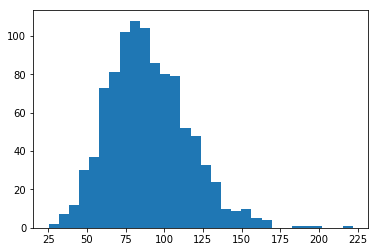

In [7]:
d = 25
n = 200

av = []
numit = 1000
for i in range(numit):
    model = linear_model(d,sigma_noise=0.0,normalized=False)
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    # normalize
    XsN = np.diag( 1/np.linalg.norm(Xs, axis = 1) ) @ Xs
    # compute H
    H = 0.5*(1 - np.arccos((XsN @ XsN.T) / 1.0000001 )/pi ) * (Xs @ Xs.T)
    U,S,V = np.linalg.svd(H)
    av += [ ys.T @ U @ np.diag(1/S) @ U.T @ ys ]
    
plt.hist( av , bins = 30)
plt.show()

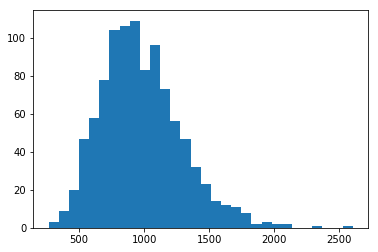

In [178]:
d = 25
n = 200

av = []
numit = 1000
for i in range(numit):
    model = linear_model(d,sigma_noise=0.0,normalized=False)
    Xs,ys = model.sample(n)
    D = [(x,y) for x,y in zip(Xs,ys)]
    # normalize
    XsN = np.diag( 1/np.linalg.norm(Xs, axis = 1) ) @ Xs
    # compute H
    H = 0.5 * ( 1 - np.arccos((XsN @ XsN.T) / 1.0000001 )/pi ) * (Xs @ Xs.T)
    U,S,V = np.linalg.svd(H)
    np.random.shuffle(ys)
    av += [ ys.T @ U @ np.diag(1/S) @ U.T @ ys ]
    
plt.hist( av , bins = 30)
plt.show()

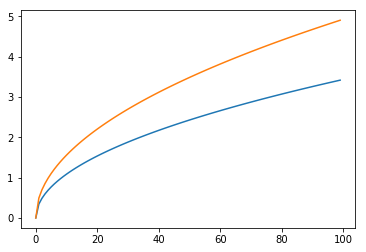

In [188]:
xs = np.linspace(0.0, 2.0, num=100)

aas = [np.sqrt(x) for x in xs]
bbs = [np.sqrt(2*x) for x in xs]

ccs = [np.sqrt(3*x) for x in xs]
dds = [np.sqrt(x) + np.sqrt(2*x) for x in xs]


#plt.plot(aas)
plt.plot(dds)
plt.plot(2*np.array(ccs))
plt.show()

# Combination of two kernels

Behaviour of the risk bound as a function on how the two kernels are combined.

model theta [ 0.33492564  1.74217542 -0.85609887 -1.77945864  0.99525071  1.98108274
  1.89928602  2.17148408 -0.3933045   0.99550494]
H1:  1.6161485960714337 9.611243657255036
H2:  0.3665963737266765 25.96054006538174


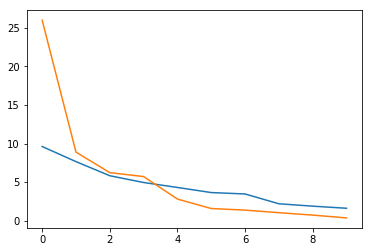

In [96]:
d = 10
n = 10
model = linear_model(d,sigma_noise=0.00,normalized=False)
#model.beta = [-1.0,1.0]
print("model theta", model.beta)
Xs,ys = model.sample(n)
D = [(x,y) for x,y in zip(Xs,ys)]

# normalize
XsN = np.diag( 1/np.linalg.norm(Xs, axis = 1)) @ Xs
Rho = XsN @ XsN.T

# compute H1 - Gram matrix of kernel 1
H1 = 0.5*(1 - np.arccos((Rho) / 1.0000001 )/pi ) * (Xs @ Xs.T)

# compute H2 - Gram matrix of kernel 2
def dual_kernel_relu(rho):
    return 1/(2*pi) * ( np.sqrt(1- (rho/1.0000001)**2) + (pi - np.arccos(rho/1.0000001))*rho )

H2 = dual_kernel_relu(Rho) * np.outer( np.linalg.norm(Xs,axis=1) , np.linalg.norm(Xs,axis=1) )

#
U,S,V = np.linalg.svd(H1)
print("H1: ", min(S1), max(S1))
#
U,S2,V = np.linalg.svd(H2)
print("H2: ", min(S2), max(S2))

plt.plot(S1)
plt.plot(S2)
plt.show()

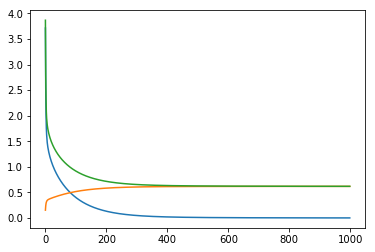

In [98]:
U,S,V = np.linalg.svd(H1)

uys = np.array( [ ys.T @ u for u in U.T] )
stepsize = 1/(2*max(S**2))

riskbound = []
kmax = 1000

part1 = [np.sqrt( 1/n * np.sum( uys**2*(1 - stepsize*(S**2))**(2*k) ) ) for k in range(1,kmax) ]
part2 = [np.sqrt( 1/(2*n) * np.sum( uys**2*( 1 - (1 - stepsize*(S**2))**(k) )**2/S**2 ) ) for k in range(1,kmax) ]

plt.plot(part1)
plt.plot(part2)
plt.plot(np.array(part1) + np.array(part2))
plt.show()

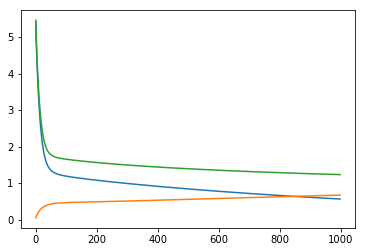

In [100]:
U,S,V = np.linalg.svd(H2)

uys = np.array( [ ys.T @ u for u in U.T ] )
stepsize = 1/(2*max(S**2))

riskbound = []
kmax = 1000

part1 = [np.sqrt( 1/n * np.sum( uys**2*(1 - stepsize*(S**2))**(2*k) ) ) for k in range(1,kmax) ]
part2 = [np.sqrt( 1/(2*n) * np.sum( uys**2*( 1 - (1 - stepsize*(S**2))**(k) )**2/S**2 ) ) for k in range(1,kmax) ]

plt.plot(part1)
plt.plot(part2)
plt.plot(np.array(part1) + np.array(part2))
plt.show()

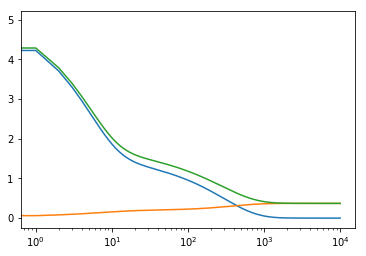

In [106]:
U,S,V = np.linalg.svd(1*H1+1*H2)
#random.shuffle(ys)

uys = np.array( [ ys.T @ u for u in U.T ] )
stepsize = 1/(2*max(S**2))

riskbound = []
kmax = 10000

part1 = np.array( [np.sqrt( 1/n * np.sum( uys**2*(1 - stepsize*(S**2))**(2*k) ) ) for k in range(1,kmax) ] )
part2 = np.array( [np.sqrt( 1/(2*n) * np.sum( uys**2*( 1 - (1 - stepsize*(S**2))**(k) )**2/S**2 ) ) for k in range(1,kmax) ] )

plt.xscale('log')
plt.plot(part1)
plt.plot(part2)
plt.plot(part1 + part2)
plt.show()

savemtx_for_logplot( np.array([part1,part2,part1+part2]),"risk_theory.dat" ) 

In [76]:
ys
random.shuffle(ys)
ys

array([ -1.60506007,  10.67039129,  -1.54041005,  -9.38244666,
         7.85407646,  -1.13401702, -10.05042246,  -4.11158492,
        -3.17703103,   1.8118581 ])

## Plot kernels

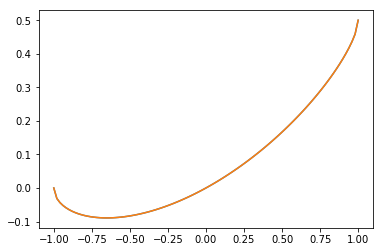

In [108]:
def dual_kernel_relu(rho):
    return 0.5*( np.sqrt(1 - (rho/1.0000001)**2)/pi + (1 - np.arccos(rho/1.0000001)/pi)*rho )

rhos = np.linspace(-1.0, 1.0, num=100)
kernel1 = [ 0.5*(1 - np.arccos(rho / 1.0000001 )/pi )*rho for rho in rhos ]
kernel2 = [ dual_kernel_relu(rho) for rho in rhos ]

plt.plot(rhos,kernel1)
#plt.plot(rhos,kernel2)
plt.show()

#np.savetxt('NNkernels.dat', np.array([rhos,kernel1,kernel2]).T) #, delimiter='')

## Risk curves

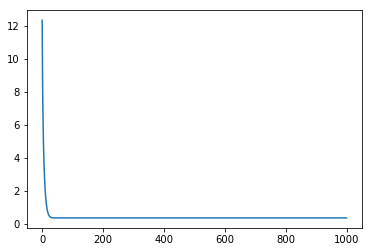

In [318]:
U,S,V = np.linalg.svd(H1)

uys = [ ys.T @ u for u in U ]
def tradeoff(s,k,eta=0.005):
    return (1 - eta*s)**(2*k) + (1 - (1 - eta*s)**k)**2 / s**2

H1T = [np.sqrt(sum([uy**2/n*tradeoff(s,k) for uy,s in zip(uys,S)])) for k in range(1000)]

plt.plot(H1T)
plt.show()

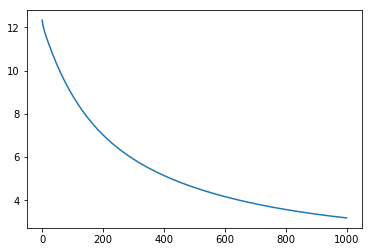

In [319]:
U,S,V = np.linalg.svd(H2)

uys = [ ys.T @ u for u in U ]
def tradeoff(s,k,eta=0.0001):
    return (1 - eta*s)**(2*k) + (1 - (1 - eta*s)**k)**2 / s

H2T = [np.sqrt(sum([uy**2/n*tradeoff(s,k) for uy,s in zip(uys,S)])) for k in range(1000)]
plt.plot(H2T)
plt.show()

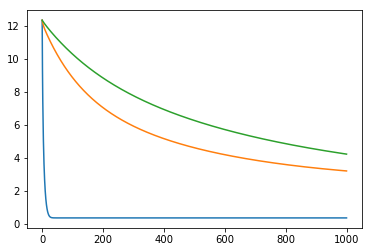

In [323]:
q = 0.5
M = q**2*H1 + (1 - q**2)*H2

U,S,V = np.linalg.svd( M )

uys = [ ys.T @ u for u in U ]
def tradeoff(s,k,eta=0.00005):
    return (1 - eta*s**2)**(2*k) + (1 - (1 - eta*s**2)**k)**2 / s**2

H12T = [np.sqrt(sum([uy**2/n*tradeoff( np.sqrt(s) ,k) for uy,s in zip(uys,S)])) for k in range(1000)]

plt.plot(H1T)
plt.plot(H2T)
plt.plot(H12T)
plt.show()